# Atelier Day 3 - Introduction to deep learning  with `tensorflow`

## About `tensorflow` and `keras`

The `numpy` library does some expensive operations outside Python using efficient code (Fortran, C/C++). However, switching back to python after each operation causes a big overhead because of unnecessary copies of the data. 

The library `tensorflow` does all the computations outside of Python: the python API is used to define a graph of operations, that will run entirely using C++ binaries. This architecture allows to get rid of the overhead. Besides, knowing the computational graph beforehand allows to parallelize and/or distribute the computations more easily. As a result, `tensorflow` can run the computations on multiple CPUs or GPUs, and on multiple servers.

However, for quick and easy model prototying, the library `keras` is simpler to use than `tensorflow`. 
Deep learning models can be constructed thanks to `keras` in few lines of python. So in this notebook, we won't see direct calls to `tensorflow`, but only to `keras`, even if the computations are done by `tensorflow`.

# Handwritten digit recognition with MNIST

For the first part of this tutorial, we will use the [MNIST](http://yann.lecun.com/exdb/mnist) dataset.
This dataset contains images representing handwritten digits. 
Each image is 28 x 28 pixels, and each pixel is represented by a number (gray level, integer value between 0 and 255). 
These arrays can be flattened into vectors of 28 x 28 = 784 numbers.
You can then see each image as a point in a 784-dimensional vector space. 
You can find interesting visualisations of this vector space [http://colah.github.io/posts/2014-10-Visualizing-MNIST/](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

For each image, its label in $\{0, 1, 2, \ldots, 9\}$ gives the digit on the image. 
In the first part of this study, we will transform the labels using one-hot encoding: labels in $\{0, 1, 2, \ldots, 9\}$ are replaced by labels in $\{ 0, 1\}^{10}$, namely $0$ is replaced by $(1, 0, \ldots 0)$, $1$ is replaced by $(0, 1, 0, \ldots 0)$, $2$ is replaced by $(0, 0, 1, 0, \ldots, 0)$, etc.

Also, MNIST data is grayscale pixels in $\{0, \ldots, 255\}$. The pixels should be normalized to belong to $[0, 1]$.
Indeed, working with big floats can lead to important numerical errors, in particular in deep learning models.

## Load the data

MNIST is a very old and standard benchmark dataset for image classification, so it's built-in (ready to be downloaded) in all machine learning libraries (including `keras` and `tensorflow`). It's already split into train and test sets.


In [1]:
from tensorflow import keras

### Import des données depuis keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("x_train : ",x_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",x_test.shape)
print("y_test  : ",y_test.shape)

x_train :  (60000, 28, 28)
y_train :  (60000,)
x_test  :  (10000, 28, 28)
y_test  :  (10000,)


The training set contains 60000 images and the test set 10000. Each image is a $28\times 28$ array.

In [2]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [3]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

The labels are encoded by integers between 0 and 9. We can see that the 10 classes have approximately the same proportion of training data (around 10% of the data in each of the ten classes): 

In [4]:
import numpy as np

np.bincount(y_train) / y_train.shape[0]

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

Let us visualize the proportions in each class for both the training and the testing sets.

<AxesSubplot:xlabel='class', ylabel='prop'>

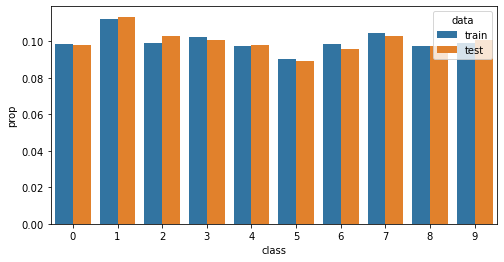

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns

# Number of classes
num_labels = 10

y_counts = pd.DataFrame({
    'data': np.array(['train'] * num_labels + ['test'] * num_labels),
    'class': np.tile(np.arange(num_labels), 2),
    'prop': np.hstack([np.bincount(y_train) / y_train.shape[0], 
                         np.bincount(y_test) / y_test.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=y_counts, ax=ax)

This is also the case for the test set.

## A first look at the data

In the next cell we illustrate the first four elements of the training data: 
pixels grayscale of the digit and their corresponding label.

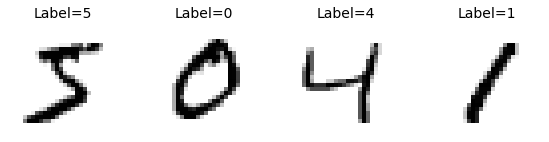

In [6]:
# PLot the first 4 elements of x_train - with label associated
plt.figure(figsize=(8, 2))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].reshape(28, 28), 
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % y_train[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()

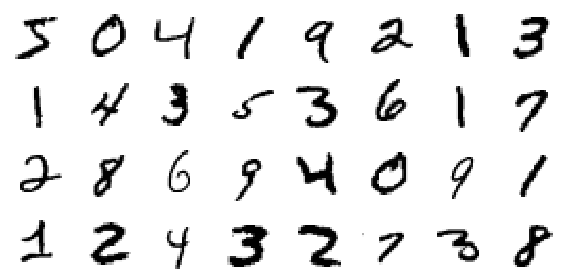

In [7]:
# PLot the first 4*8 elements of x_train
n_rows = 4
n_cols = 8
plt.figure(figsize=(8, 4))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()

The second character is a 0 digit, encoded in grayscale matrix as follows. Note that in the viewing below, we can read the digit: this corresponds to non-zero values in the image.

In [8]:
print(np.array2string(x_train[1].astype(np.int32).reshape(28, 28), 
                      max_line_width=150))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253 159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 253 252 252  96 18

## Normalization and preprocessing of the data

We need to normalize the images and one-hot encode the labels.

**Warning:** call this cell only once (otherwise you'll divide several times by 255, which might be problematic later on !).

In [9]:
# BEWARE : run only ONCE !!!
x_test = x_test / x_train.max() ## Be careful to normalize test and train with same values - those from TRAIN
x_train = x_train/ x_train.max()
print(x_train.min(axis=None), x_train.max(axis=None))

0.0 1.0


Let us one-hot encode the labels. Remember the format for y_train. We use a fonction from `keras` called `utils.to_categorical`to one-hot encode into vectors of length `num_labels`.

In [10]:
# Old format of y
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [11]:
# BEWARE : run only ONCE !!!
# convert class vectors into binary class matrices
y_train = keras.utils.to_categorical(y_train, num_labels)
y_test = keras.utils.to_categorical(y_test, num_labels)

# New format of y
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

# A first model: softmax (or multinomial logistic) regression 

In this first part, we are not going to use the fact that our data $x$ are images. Indeed, each image $x$ is a $p\times p = 28\times 28$ matrix ( $x=(x_{ij} )$ ) with some specific neighborhood structure. But here we treat each image $x$ as a $pp = 784$ vector ( $x = (x_{j})$ ) and we forget about the neighbourhing structure. 

We want to classify these pictures or equivalently to predict the digit $k$ varying in $\{0, \ldots, 9\}$ they represent.
A simple model allowing to do that is softmax regression.

## Description of the model


The idea behind this model is to produce a score for each input image $x$ using a simple linear model. 
To do so, we assume that belonging to a class $k$ (corresponding to digit $k$) can be expressed by a weigthed sum of the pixel intensities, with weights $W_{k, 1}, \ldots, W_{k, 784}$ plus a bias (or intercept) $b_k$ capturing a variability independent of the input:
$$
\text{score}_k(x) = \sum_{j=1}^{784} W_{k, j} x_j + b_k,
$$
These scores are sometimes called the "logits" in the deep learning community.
We then use the softmax function to convert the scores into predicted probabilities $p_k=\mathbb{P}(y=k|x)$:
$$
\forall k =0,\ldots,9,\quad p_k(x) = \text{softmax}(\text{score}_k(x)) = \frac{\exp(\text{score}_k(x))}{\sum_{\ell =0}^{9}\exp(\text{score}_{\ell}(x))}.
$$

## Define the computational graph of softmax regression

To train the model parameters (the bias $b_k$ and the weights $W_{k, j}$ where $k=0, \ldots, 9$ and $j=1, \ldots, 784$), the considered goodness-of-fit or loss is the negative log-likelihood defined by the **cross-entropy** between the score $p(x)=(p_0(x),\dots,p_9(x))$ and the true label $y=(y_0,\dots,y_9)$ (one-hot encoding format) :
$$
\ell(y,p(x))= - \sum_{k=0}^{9} y_{k} \log(p_k(x)).
$$

For this first model, we optimize with respect to the parameters $(\boldsymbol{W}, \boldsymbol{b})$ the total loss $F(\boldsymbol{W}, \boldsymbol{b})$ over the training set $(x^i,y^i)_{1\le i \le n_{\text{train}}}$ expressed as
$$
F(\boldsymbol{W}, \boldsymbol{b}) = \sum_{i=1}^{n_{\text{train}}} \ell(y^i,p(x^i)) = - \sum_{i=1}^{n_{\text{train}}} \sum_{k=0}^{9} y^i_{k} \log(p_k(x^i)).
$$
We simply use stochastic gradient descent over small batches of data. It can be done easily with `TensorFlow`, as it (automatically and efficiently) computes the gradient from the graph, then apply an optimization algorithm of your choice to perform the parameters update.

Finally, we monitor the optimization procedure by looking at the evolution of the accuracy computed on the test set along the iterations of the optimization algorithm. The accuracy is computed as the fraction of images $x^i$ in the test set whose true label $y^i$ is equal to the predicted one $p(x^i)$: 
$$
\frac {1} {n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} 1\{p(x^i) =y^i\}.
$$

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# We define the computational graph of the model 
## The definition is sequential: we stack layers
model_softmax = Sequential() # This first line initiates the process 
## Then we flatten the data: replace 28 * 28 matrices by flat vectors
## This is always necessary before feeding data to a fully-connected layer (Dense object)
model_softmax.add(Flatten(input_shape=(28,28), name='flatten')) # This defines the input layer 
## We add one dense (fully connected layer) with softmax activation function
## Since it's the last layer, it's the output layer and we need to give the size of output data - we output 10 classes 
model_softmax.add(Dense(num_labels, activation='softmax', name='output'))

# We "compile" this model, 
model_softmax.compile(
    # specifying the loss as the cross-entropy
    loss=keras.losses.categorical_crossentropy,
    # We choose the Adagrad solver, but you can choose others
    optimizer=keras.optimizers.Adagrad(),
    # We will monitor the accuracy on a testing set along optimization
    metrics=['accuracy']
    )

# Let's have a look at the model characterictics
model_softmax.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


2022-06-24 18:46:50.024795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the model

For the training of the model, we need to decide when we stop the iterations of the SGD optimizer. For this, we use the concept of `epoch`: one `epoch` corresponds on average to one pass through the dataset. This means that for example with mini-batches of sizes $\alpha=20\%$ of the data, an epoch corresponds to $1/\alpha=1/0.2=5$ iterations. Indeed, after five iterations where we visited $20\%$ of the data at each iteration, we have seen all data on average; this makes 1 epoch.

In the example below, we have $n=60 000$ and batch size $256$, which means that at each iteration, we consider only $256/60000 \simeq 0.4\%$ (4 per mille) of the total dataset. Here, one epoch consists in $\lceil 60000/256\rceil=235$ iterations.

In [13]:
# size of the batches
batch_size = 256 # always some power of 2

# number of epochs
epochs = 50

# Train the model
history_softmax = model_softmax.fit(x_train, y_train,  # the training data 
                                    batch_size=batch_size, # batch sizes for the stochastic gradient 
                                    epochs=epochs, # number of epochs
                                    verbose=1, # Verbosity mode: 1 = progress bar
                                    validation_data=(x_test, y_test) # the validation set - the `fit` function only uses this to compute the validation losses and accuracy at each end of an epoch
                                   )

# And compute its accuracy on test set - corresponds to the value above, outputed at the last epoch
score_softmax = model_softmax.evaluate(x_test, y_test, verbose=0) # Verbosity mode: 0 = silent
print('Test loss:', score_softmax[0]) # The first entry corresponds to loss
print('Test accuracy:', score_softmax[1]) # the second entry is accuracy

Epoch 1/50
235/235 [==============================] - 2s 6ms/step - loss: 2.0717 - accuracy: 0.3276 - val_loss: 1.8434 - val_accuracy: 0.5139
Epoch 2/50
235/235 [==============================] - 0s 2ms/step - loss: 1.7191 - accuracy: 0.5849 - val_loss: 1.5829 - val_accuracy: 0.6574
Epoch 3/50
235/235 [==============================] - 0s 2ms/step - loss: 1.5113 - accuracy: 0.6813 - val_loss: 1.4113 - val_accuracy: 0.7202
Epoch 4/50
235/235 [==============================] - 0s 2ms/step - loss: 1.3676 - accuracy: 0.7267 - val_loss: 1.2873 - val_accuracy: 0.7508
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 1.2609 - accuracy: 0.7528 - val_loss: 1.1931 - val_accuracy: 0.7711
Epoch 6/50
235/235 [==============================] - 0s 2ms/step - loss: 1.1781 - accuracy: 0.7694 - val_loss: 1.1186 - val_accuracy: 0.7843
Epoch 7/50
235/235 [==============================] - 0s 2ms/step - loss: 1.1116 - accuracy: 0.7811 - val_loss: 1.0581 - val_accuracy: 0.7935
Epoch 

Notice that the loss and accuracy computed on the test set are exactly the same values as those output at the last epoch during the training. 

In [14]:
# Let's define a plot function that we will call many times to visualize Test accuracy and Train accuracy along the different epochs
def plot_history(history, title=''):
    plt.figure(figsize=(7, 5))
    plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
    plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
    plt.legend(fontsize=14)
    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.tight_layout()

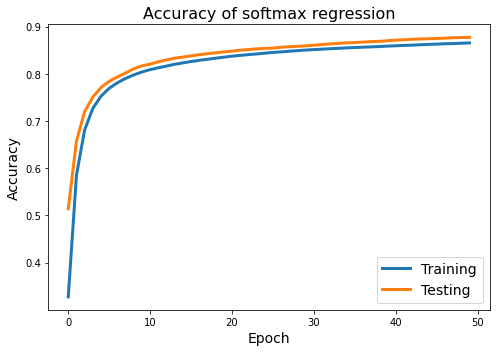

In [15]:
plot_history(history_softmax, title='Accuracy of softmax regression')

The training error is always increasing along the number of epochs. The test error does not necessarily behave the same way: it could decrease at some point, due to overfitting the training set.

## Visualisation of the model weights

Weight matrices plots show that the learned weights are consistant with the digits they should predict (see below).
You should be able to see rough shapes corresponding to the digits 0, 1, 2, 3, etc. (If the number of epochs above is not to small). 

In [16]:
# We output the estimated parameters
W, b = model_softmax.get_layer("output").get_weights()

In [17]:
# These are the weights on each pixel, for each of the ten classes 
W.shape

(784, 10)

In [18]:
# These are the biases for each of the ten classes
b.shape

(10,)

In [19]:
b

array([-0.06638156,  0.10986986, -0.01766081, -0.0604003 ,  0.05054165,
        0.05988722, -0.02175187,  0.05792516, -0.10938758, -0.01701022],
      dtype=float32)

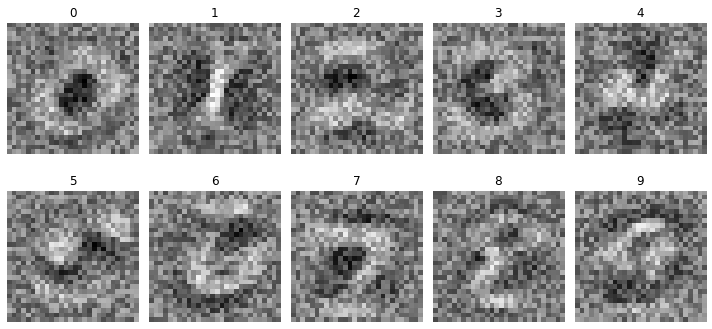

In [20]:
# Let's transform the 10 coefficients W_k into 28x28 arrays 
imgs = W.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='gray')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()

## Prediction of the labels for new images

In [21]:
# We predict the labels of the images from the test set
pred_log = model_softmax.predict(x_test)

In [22]:
# look at the first predicted label on the test set
pred_log[0]

array([3.4943111e-03, 2.9716373e-04, 2.7053289e-03, 5.6378413e-03,
       2.1643713e-03, 2.7044478e-03, 4.7077113e-04, 9.5997161e-01,
       3.1672355e-03, 1.9386953e-02], dtype=float32)

In [23]:
# You can also have more information: the probability of being in each class
model_softmax(x_test)[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([3.4943158e-03, 2.9716402e-04, 2.7053324e-03, 5.6378483e-03,
       2.1643743e-03, 2.7044513e-03, 4.7077154e-04, 9.5997149e-01,
       3.1672397e-03, 1.9386979e-02], dtype=float32)>

The probabilities are very separated.

The model has predicted label 7. Let's look at the corresponding image

(-0.5, 27.5, 27.5, -0.5)

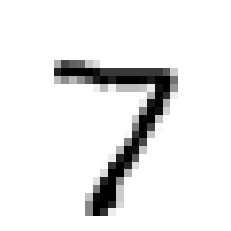

In [24]:
plt.imshow(x_test[0].reshape(28, 28),
           interpolation="none", cmap="gray_r")
plt.axis("off")

## Saving the model

In the next cell we save the model in a file, so that it can be used later on. This means that you can later re-use the trained model on new data (without training it again), but you can also continue the training, i.e. add new epochs, **from where you stopped**.
This is particularly helpful when the training of models is long: we can save it every once in a while, and 
eventually continue to train it later on.

**Warning:** You need to create a `models` folder in the folder containing this notebook to run the next commands.

In [25]:
ls models/

mnist_cnn.h5                  mnist_softmax.h5
mnist_cnn_history.pkl         mnist_softmax_history.pkl
mnist_ffnn.h5                 notmnist_softmax.h5
mnist_ffnn_history.pkl        notmnist_softmax_history.pkl


In [26]:
import os 
import pickle as pkl

models_path = 'models/'
model_softmax.save(os.path.join(models_path, 'mnist_softmax.h5'))
with open(os.path.join(models_path, 'mnist_softmax_history.pkl'), 'wb') as f:
    pkl.dump(history_softmax.history, f)

In [27]:
# ----- If you want to reload it and use as it is
# model_softmax = keras.models.load_model(os.path.join(models_path, 'mnist_softmax.h5'))

In [28]:
# ---- If you want to continue the training further

history_softmax = model_softmax.fit(x_train, y_train,  # the training data 
                                    batch_size=batch_size, # batch sizes for the stochastic gradient 
                                    epochs=1, # do just one additional epoch here
                                    verbose=1, # Verbosity mode: 1 = progress bar
                                    validation_data=(x_test, y_test) # the validation set - the `fit` function only uses this to compute the validation losses and accuracy at each end of an epoch
                                   )

235/235 [==============================] - 1s 2ms/step - loss: 0.5590 - accuracy: 0.8662 - val_loss: 0.5334 - val_accuracy: 0.8775


You can see that the accuracy corresponds to an additional epoch, not just one starting from random initialization.

## Conclusion with MNIST

You should have reached an accuracy around 0.9 with this simple model (if number of epochs is enough).
**Too easy !** You almost solved the problem using a simple softmax regression and without exploiting the neighborhood structure of the pixels. 
Weight matrices plots show that the learned weights are consistant with the digits they should predict (see above ; you should be able to see rough shapes corresponding to the digits 0, 1, 2, 3, etc.)

# Feed-Forward Neural Network (FFNN)

Now, let's build a more elaborate model using more layers.
Let's start with a feed-forward neural net (FFNN) with one hidden layer using Relu activation.
Note that in this second model, we still do not use the specific structure of the image. 

## Description

The softmax regression is a linear model, with $(784+1)\times 10 =   7850$ parameters. 
It is easy to fit, numerically stable, but might be too simple for some tasks. 
The aim of neural networks is to consider nonlinear models, while keeping the nice features of linear ones. 
The idea is to keep parameters into linear functions, and link these simple linear models using non linear operations.

A simple nonlinearity which is often used to do this is the **Rectified Linear Unit**: $\quad \text{ReLU}(x) = \max(0, x)$


## Computational graph for a single hidden layer FFNN

We create the graph for a fully connected feed-forward neural network with one hidden layer with 128 units and a relu activation function. We use what you did for softmax regression : we just need to add a **single line** to the code creating the softmax regression.

In [29]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adagrad

# We define the computational graph of the FFNN
model_ffnn = Sequential(name="FFNN") # We initialize the model definition and name it "FFNN"
model_ffnn.add(Flatten(input_shape=(28,28), name="flatten")) # we start by flattening the images 
## The new next line adds the extra hidden layer
model_ffnn.add(Dense(128, activation="relu", name="hidden")) # a hidden dense layer - with Relu activation - and width 128 (you could change the width)
model_ffnn.add(Dense(num_labels, activation="softmax", name="output")) # the output layer - output has size 10= the number of classes - with Softmax activation 

# We "compile" this model, 
model_ffnn.compile(
    optimizer=Adagrad(), # choose the optimizer
    loss=categorical_crossentropy, # define the loss function
    metrics=["accuracy"] # define the metric that is output at each epoch, to monitor the training phase
)

## You could choose another optimizer below - by compiling differently the model
#model_ffnn.compile(
#    optimizer=Adam(learning_rate=1e-2), # here we also specify the learning rate of the algorithm
#    loss=categorical_crossentropy, 
#    metrics=["accuracy"]
#)

Look at a description of the model we just defined:

In [30]:
# Let's have a look at the model characterictics
model_ffnn.summary()

Model: "FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden (Dense)              (None, 128)               100480    
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Now, we train the model: need to choose a batch size (in general some power of 2) and a number of epochs. 

In [31]:
# Train the model
batch_size = 256 
# number of epochs
epochs = 20

# Fit the model 
history_ffnn = model_ffnn.fit(x_train, y_train, # training set 
                            validation_data=(x_test, y_test), # we input the test set here to monitor the iterations
                            batch_size=batch_size, 
                            epochs=epochs
                            )

# Compute the resulting loss and accuracy on the test set - This is also obtained on the last epoch of the fit with verbose mode
score_ffnn = model_ffnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_ffnn[0])
print('Test accuracy:', score_ffnn[1])

Epoch 1/20
235/235 [==============================] - 1s 4ms/step - loss: 2.0115 - accuracy: 0.4147 - val_loss: 1.7418 - val_accuracy: 0.6496
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 1.5654 - accuracy: 0.7035 - val_loss: 1.3679 - val_accuracy: 0.7602
Epoch 3/20
235/235 [==============================] - 1s 3ms/step - loss: 1.2595 - accuracy: 0.7705 - val_loss: 1.1156 - val_accuracy: 0.8030
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 1.0536 - accuracy: 0.8012 - val_loss: 0.9470 - val_accuracy: 0.8252
Epoch 5/20
235/235 [==============================] - 1s 3ms/step - loss: 0.9137 - accuracy: 0.8194 - val_loss: 0.8316 - val_accuracy: 0.8372
Epoch 6/20
235/235 [==============================] - 1s 3ms/step - loss: 0.8156 - accuracy: 0.8310 - val_loss: 0.7493 - val_accuracy: 0.8471
Epoch 7/20
235/235 [==============================] - 1s 3ms/step - loss: 0.7441 - accuracy: 0.8408 - val_loss: 0.6883 - val_accuracy: 0.8544
Epoch 

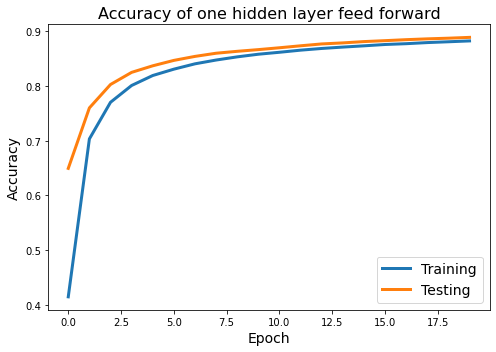

In [32]:
# Look at the accuracy curves on training and test sets 
plot_history(history_ffnn, title='Accuracy of one hidden layer feed forward')

In [33]:
# Save this model
models_path = "./models"

model_ffnn.save(os.path.join(models_path, 'mnist_ffnn.h5'))
with open(os.path.join(models_path, 'mnist_ffnn_history.pkl'), 'wb') as f:
    pkl.dump(history_ffnn.history, f)

## Home exercise

- Run 60 epochs and look at the training and testing accuracy curves.
- compare the results with the simple softmax regression. 
- Modify the width and the optimizer to search for the best Test accuracy. 


# Convolutional Neural Network (CNN)

In practice, increasing the width (dimension) of hidden layers is not very effective. 
It is often a better idea to add more layers. 
Intuitively, if the phenomenon you try to learn has a hierarchical structure, adding more layers can be interpreted as a way to learn more levels of abstraction. 
For example, if you are trying to recognize objects, it is easier to express shapes from edges and objects from shapes, than to express objects from pixels. 
Thus, a good design should try to exploit this hierarchy.

In particular cases, such as grid-like data (time series, images), you might want to detect a pattern which can happen in different locations of the data. 
For example, you try to detect a cat, but the cat can be in the middle or the left of the picture. 
Thus you need to build a model which is translation invariant: it is easier to learn how to recognize an object independently of its location. 


## Description

When two inputs might contain the same kind of information, then it is useful to share their weights and train the weights jointly for those inputs to learn statistical invariants (things that don't change much on average across time or space). 
Using this concept on images leads to convolutional neural networks (CNNs);  on text, it results on recurrent neural networks (RNNs). 
When using CNNs, you set weights to a small kernel that will be used to perform a convolution across the image.

The image is represented as a 3-dimensional tensor: (width, height, depth). Width and height charecterize the size of the image (eg. 28 x 28 pixels), and depth the color space (e.g. 1 for gray levels, 3 for RGB pictures since each pixel is represented by a triplet $(R,G,B)$).

The convolution will map patches of this image, combined with the convolution kernel, for example

$$
\text{output} = \text{ReLU}(\text{patch} \times W + b).
$$

Depending on the shape of the $W$ weights tensor, the tensor resulting from the convolution can have a different depth. Note that in the context of a CNN, the "kernel" can also be called a "filter". 

Performing the convolution between the image and the kernel consists in moving the kernel across the image, and producing an output for each patch. 
The way you move across the image is defined by two parameters:

- **Stride:** the stride is the number of pixels you are shifting each time you move your kernel during the convolution.
- **Padding:** defines what happens when the kernel reaches a border of the image when doing the convolution. 
"Valid" padding means that you stop at the edge, while "Same" padding allows to go off the edge and pad with zeros so that the width and the height of the output and input tensors are the same.

The figures below were taken from <a href="https://fidle.cnrs.fr/">Fidle<a>.


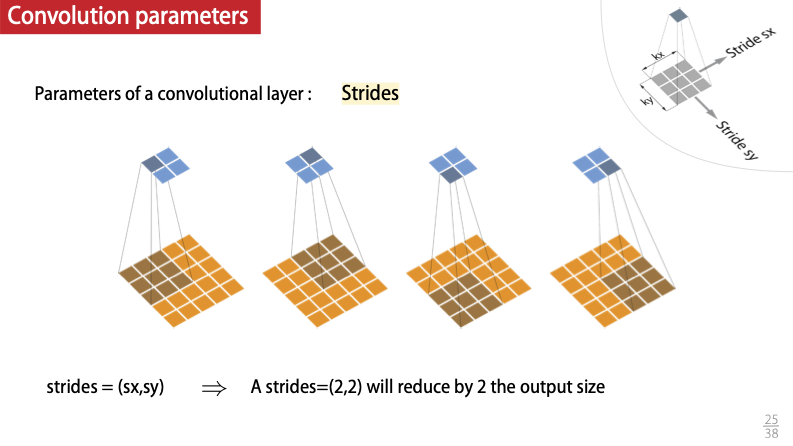

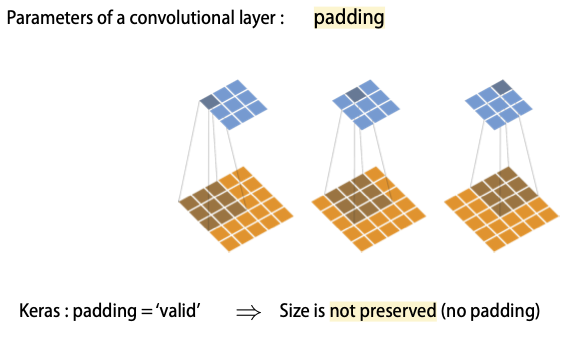

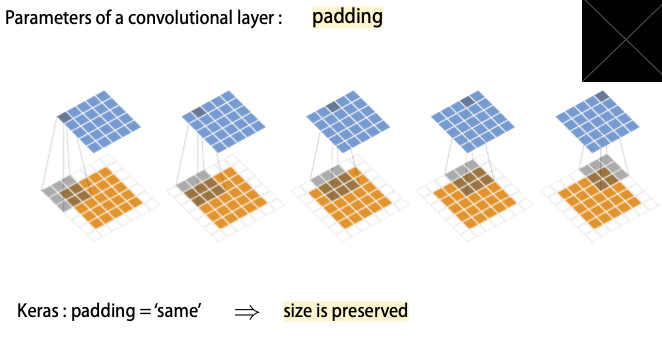

For example, a convolution with a stride $> 1$ and valid padding results in a tensor of smaller width and height. 

You can compute the size of a tensor after convolution using the following formulas: 

**Valid padding**
$$
\text{out}_{\text{height}} = \bigg\lceil \frac{\text{in}_{\text{height}} - \text{kernel}_{\text{height}} + 1}{\text{stride}_{\text{vertical}}} \bigg\rceil \quad \text{ and } \quad
\text{out}_{\text{width}} = \bigg\lceil \frac{\text{in}_{\text{width}} - \text{kernel}_{\text{width}} + 1}{\text{stride}_{\text{horizontal}}} \bigg\rceil
$$

**Same padding**
$$
\text{out}_{\text{height}} = \bigg\lceil \frac{\text{in}_{\text{height}}}{\text{strides}_{\text{vertical}}} 
\bigg\rceil \quad \text{ and } \quad 
\text{out}_{\text{width}} = \bigg\lceil \frac{\text{in}_{\text{width}}}{\text{strides}_{\text{horizontal}}} \bigg\rceil
$$

**Example.**
Assume the input tensor is 28x28x3 and the convolution kernel takes in 4x4x3 tensors and outputs 1x1x32 tensors (height x width x depth), i.e the kernel takes in a patch of size 4x4 and depth 3, and outputs a patch of size 1x1 and depth 32. To do so, the weights tensor $W$ should be 3x3x3x32 (in-height, in-width, in-depth, out-depth). 
If we are using a stride of 1, the output tensor will be 28x28x32 with same padding, and 25x25x32 with valid padding.
Using a stride of 2, the output tensor will be 14x14x32 with same padding, and 13x13x32 with valid padding.


**Pooling.** Striding is an agressive method to reduce the image size. 
Instead, it can be a better idea to use a stride of 1 and to combine the convolution's outputs being in some neighborhood. Such an operation combining elements of a tensor is called **pooling**. 
Neighborhoods are defined by the pooling window dimension (width x height) and the strides you use when moving this window across the image.

**Example.**
Max pooling aggregates several outputs in a neighborhood $N$ using a max operation: 

$$
\text{output}'_i = \max_{j \in N}\text{output}_j, \quad i \in N.
$$
The formulas to compute the size of the ouput tensor are the same as for convolution padding and striding.

Many successful architectures stack convolution layers in a "pyramidal" way: each convolution layer results in a tensor with increased depth and decreased height and width. 
Roughly, increasing the depth increases the complexity of the semantics of your representation, and allows to keep the relevant information in a smaller space (height x width). 

## Define the computational graph of our CNN

We implement a CNN having the following structure:

- Convolutional layer with 32 filters and 3 * 3 kernel sizes and 'relu' activation (use the `Conv2D` object)
- Convolutional layer with 64 filters and 3 * 3 kernel sizes and 'relu' activation (use the `Conv2D` object)
- Max pooling with pool size 2 * 2 (use the `MaxPooling2D` object)
- Dropout with probability 0.25 (use the `Dropout` object)
- Dense layer with 128 units with relu activation (Beware: a dense layer only accepts vector objects as inputs. So you need to flatten the object before that layer)
- Dropout with probability 0.5
- Dense output layer with softmax activation

Note: contrary to the 2 previous models (softmax regression and FFNN), we are now using the neighbourhing structure of the images. Thus, the first layer is not a flattening layer! Moreover, we need to input images as 3-dimensional arrays, so now the images are $28\times 28\times 1$.

In [34]:
# Let's reload the dataset because: 
# we gonna leave the y labels in their original format (no one-hot encoding)
# and we need to reshape the images to account for their depth (equal to one here)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1,28,28,1)
x_test  = x_test.reshape(-1,28,28,1)

print("x_train : ",x_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",x_test.shape)
print("y_test  : ",y_test.shape)

x_train :  (60000, 28, 28, 1)
y_train :  (60000,)
x_test  :  (10000, 28, 28, 1)
y_test  :  (10000,)


In [35]:
# Do not forget the normalization
# BEWARE to run this only ONCE
x_test = x_test / x_train.max() ## Be careful to normalize test and train with same values 
x_train = x_train/ x_train.max()
print(x_train.min(axis=None), x_train.max(axis=None))

0.0 1.0


In [36]:
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D

# Be careful that the order of the layers is important !
model_cnn = Sequential() # initialize the model 
model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="conv1", input_shape=(28,28,1))) # First convolutional layer
model_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="conv2")) # Second convolutional layer
model_cnn.add(MaxPooling2D(pool_size=(2, 2), name="pool")) # Pooling layer
model_cnn.add(Dropout(rate=0.25, name="dropout1")) # Dropout layer
model_cnn.add(Flatten(name="flatten")) # We need to flatten the neurons before feeding them into a dense layer 
model_cnn.add(Dense(units=128, activation="relu", name="dense1")) # Dense layer 
model_cnn.add(Dropout(rate=0.5, name="dropout2")) # Second dropout layer
model_cnn.add(Dense(units=num_labels, activation="softmax", name="output")) # An output dense layer - activation is softmax

# Compile the model
model_cnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy", # ici on n'a pas fait du one-hot encoding donc la fonction s'appelle sparse_** au lieu de **
    metrics=["accuracy"],
)


In [37]:
# Characteristics of the model
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 conv2 (Conv2D)              (None, 24, 24, 64)        18496     
                                                                 
 pool (MaxPooling2D)         (None, 12, 12, 64)        0         
                                                                 
 dropout1 (Dropout)          (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense1 (Dense)              (None, 128)               1179776   
                                                                 
 dropout2 (Dropout)          (None, 128)              

Here we train the model with batch size $516$. So now, one epoch consists in $\lceil 60000/516\rceil=117$ iterations (in fact 118, because it's an even number). With only 2 epochs (you can run more, but it's long...) we use on average $516/60000*2= 1.7\%$ of the dataset only !

In [38]:
# Train the model 
history_cnn = model_cnn.fit(
    x_train, y_train, 
    validation_data=(x_test, y_test),
    epochs=2,
    batch_size=512
)

Epoch 1/2
118/118 [==============================] - 68s 571ms/step - loss: 0.3959 - accuracy: 0.8770 - val_loss: 0.0794 - val_accuracy: 0.9763
Epoch 2/2
118/118 [==============================] - 63s 534ms/step - loss: 0.1061 - accuracy: 0.9682 - val_loss: 0.0690 - val_accuracy: 0.9781


In [39]:
# Evaluate its accuracy on the training set
score_cnn = model_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_cnn[0])
print('Test accuracy:', score_cnn[1])

Test loss: 0.06899480521678925
Test accuracy: 0.9781000018119812


Even with a very small amout of data (around 1000 images only), we have already obtained a very high accuracy on the test set!

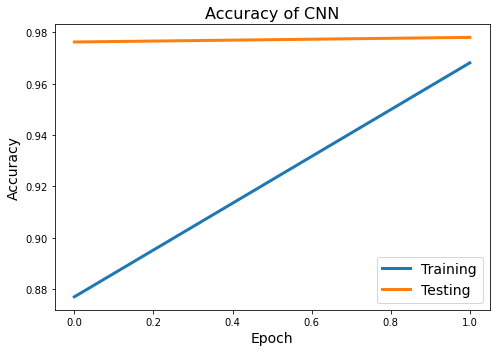

In [40]:
# Visualize accuracy
plot_history(history_cnn, title='Accuracy of CNN')

In [41]:
# save the model and its history using the following cell to continue to train it later
model_cnn.save(os.path.join(models_path, 'mnist_cnn.h5'))
with open(os.path.join(models_path, 'mnist_cnn_history.pkl'), 'wb') as f:
    pkl.dump(history_cnn.history, f)

# MNIST is too easy: let's classify weird letters now (notMNIST)

MNIST is a very very **clean** dataset. Digits are rescaled, smoothed, centered, and pixel values are normalized beforehand. Let's switch to a slightly harder dataset: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

This time, labels are letters from 'A' to 'J' (10 classes, again). 
These letters are taken from digital fonts instead of handwriting pictures. 
We will use a reduced amount of data to ensure a reasonable training time. 
The training set you will use has 200K labelled examples, while the validation and test sets both contain 10K labelled examples.

**Note** : The notMNIST data that we'll load is already normalized in [-0.5, 0.5] with labels in 0,...,9.


## Load the notMNIST dataset

In [42]:
# Load the notMNIST dataset from your local copy - in the directory 'data'

#import pickle as pkl
import gzip

with gzip.open('data/notMNIST_100.pkl.gz', 'rb') as f:
    data = pkl.load(f)

In [43]:
#look at the keys of the dictionary
data.keys()

dict_keys(['test_dataset', 'valid_labels', 'test_labels', 'train_dataset', 'train_labels', 'valid_dataset'])

The dataset comes divided into 3 parts: train, test and valid. Indeed, when the model has hyperparameters (not the case here), we sometimes distinguish a `validation` set that is used to train these hyperparameters only. Then, the NN is tested on a `test`set.


In [44]:
#from tensorflow import keras
#from tensorflow.keras import backend as K

# Sizes of the images
img_rows, img_cols = 28, 28
# Number of labels
num_labels = 10

# Images from train, valid and test sets 
x_train = data['train_dataset'].reshape(-1,img_rows, img_cols,1)
x_valid = data['valid_dataset'].reshape(-1,img_rows, img_cols,1)
x_test = data['test_dataset'].reshape(-1,img_rows, img_cols,1)

# Labels from train, valid and test sets 
# Transform classes in 0,...9 into one-hot-encoding (vectors of size 10 with just one value equal to one)
y_train = keras.utils.to_categorical(data['train_labels'])
y_valid = keras.utils.to_categorical(data['valid_labels'])
y_test = keras.utils.to_categorical(data['test_labels'])

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'training samples')
print(x_valid.shape[0], 'validation samples')
print(x_test.shape[0], 'testing samples')

x_train shape: (100000, 28, 28, 1)
x_valid shape: (10000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (100000, 10)
y_valid shape: (10000, 10)
y_test shape: (10000, 10)
100000 training samples
10000 validation samples
10000 testing samples


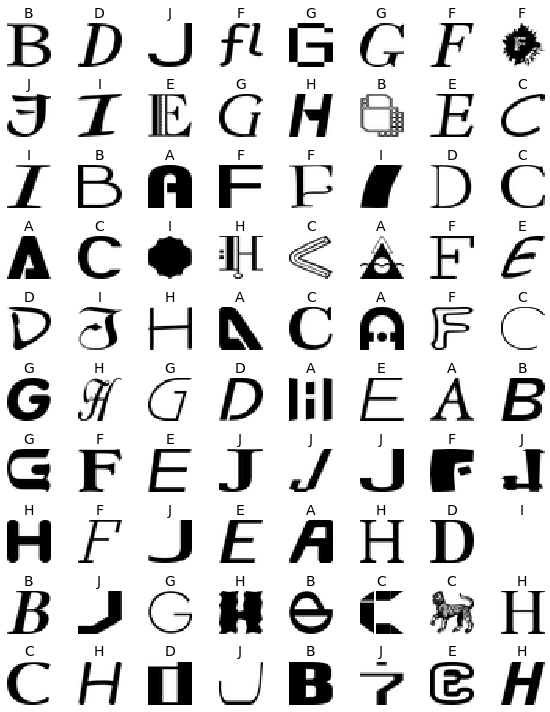

In [45]:
#import matplotlib.pyplot as plt
#%matplotlib inline

# plt.figure(figsize=(8, 4))
n_rows = 10
n_cols = 8
plt.figure(figsize=(n_cols, n_rows))

# Transform the labels in 0,...,9 into letters in A,...,J
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def get_label(y):
    return letters[y.argmax()]

# Let's have a look at the dataset 
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(get_label(y_train[i]), fontsize=14)
    ax.axis("off")
plt.tight_layout()

You can already see that the dataset contains very strange examples.

## Exercise: Training a softmax model on notMNIST

- train a softmax regression : start with a small number of epochs, and increase the number of epochs later. Keep in mind the size of dataset you are using on average
- visualize the weights
- plot the accuracy curves
- predict the labels of images from the test set and plot some of these images together with predicted label
- save the model and its history 

In [46]:
# Your answer

## Solution

In [47]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Flatten

# We define the model 
model_softmax = Sequential(name="NotMnistSM")
model_softmax.add(Flatten(input_shape=(28,28,1), name='flatten')) # we first flatten the images
model_softmax.add(Dense(num_labels, activation='softmax', name='output')) # the output is a dense layer with 10 classes

# Compile the model
model_softmax.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(),
    metrics=['accuracy']
)

# Let's look at the model characteristics
model_softmax.summary()

# Now train the model 
batch_size = 256
epochs = 10
# Below we monitor the learning phase on 'valid' dataset
history_softmax = model_softmax.fit(x_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_test, y_test))
# Look at the accuracy on test set
score_softmax = model_softmax.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score_softmax[0])
print('Test accuracy:', score_softmax[1])

Model: "NotMnistSM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
391/391 [==============================] - 1s 2ms/step - loss: 1.6135 - accuracy: 0.5424 - val_loss: 1.1194 - val_accuracy: 0.7719
Epoch 2/10
391/391 [==============================] - 1s 2ms/step - loss: 1.1379 - accuracy: 0.7353 - val_loss: 0.8784 - val_accuracy: 0.8231
Epoch 3/10
391/391 [==============================] - 1s 2ms/step - loss: 0.9982 - accuracy: 0.7627 - val_loss: 0.7712 - val_accuracy: 0.8383
Epoch 4/10
391/391 [====

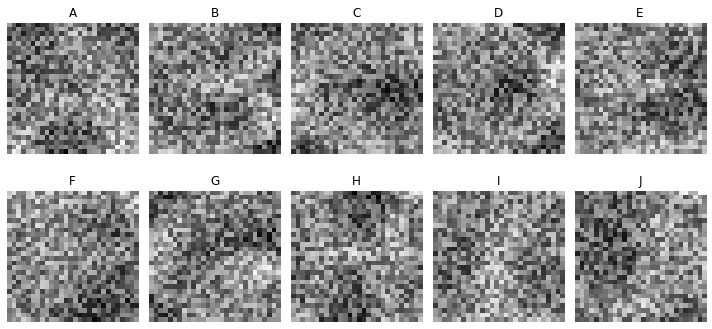

In [48]:
# Visualize the weights 

weights, biases = model_softmax.get_layer('output').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='gray')
    ax.axis('off')
    ax.set_title(letters[i])
plt.tight_layout()


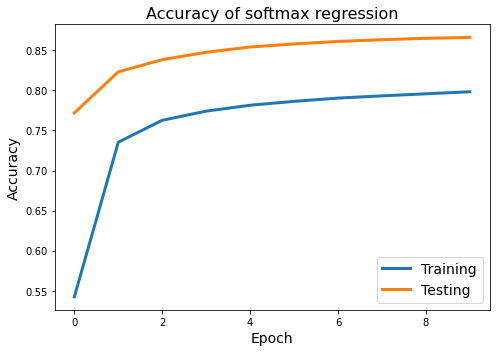

In [49]:
# Plot the accuracy curves
plot_history(history_softmax, title='Accuracy of softmax regression')

In [50]:
# Predict the labels of the images in the test set
y_pred = model_softmax.predict(x_test)

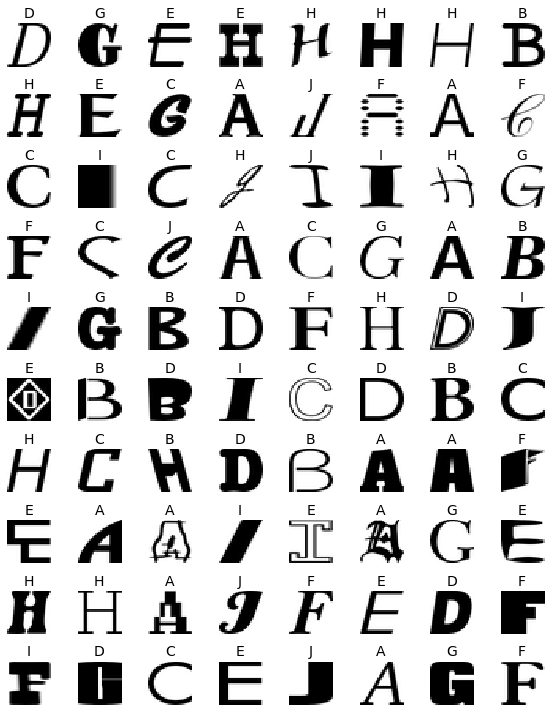

In [51]:
# Let's have a look at the results
# plt.figure(figsize=(8, 4))
n_rows = 10
n_cols = 8
plt.figure(figsize=(n_cols, n_rows))

# Images from test set and predicted labels
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_test[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(get_label(y_pred[i]), fontsize=14)
    ax.axis("off")
plt.tight_layout()

You can see that the job is more difficult and there are some errors.

In [52]:
# save the model and its history using the following cell to continue to train it later
model_softmax.save(os.path.join(models_path, 'notmnist_softmax.h5'))
with open(os.path.join(models_path, 'notmnist_softmax_history.pkl'), 'wb') as f:
    pkl.dump(history_softmax.history, f)

## Exercise: Training a one-layer FFNN on notMNIST

- Train FFNN with one hidden layer with 128 units
- visualize the weights
- plot the accuracy curves
- predict the labels of images from the test set and plot some of these images together with predicted label
- save the model and its history

In [53]:
# Your answer

## Exercise: Training a deeper CNN for notMNIST

Train a CNN with the following structure:
- Convolutional layer with 32 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25
- Dense layer with 1024 units
- Dropout with probability 0.5
- Dense output layer with softmax activation

Use the Adam solver. Train for 20 epochs or more (this might take a loooong) time.

You should achieve >= 97% accuracy on test set

- Save the model and visualize the last fully connected layers

In [54]:
# Your answer

## Solution

In [55]:
# Define the computational graph of our CNN
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28,28,1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (5, 5), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten()) # You ALWAYS need to flatten the image before feeding it to DenseCNN
model_cnn.add(Dense(1024, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_labels, activation='softmax'))

# Compile the model
model_cnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.RMSprop(),
    metrics=['accuracy']
)

# Look at its summary
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1024)             

In [56]:
# Train the model 
batch_size = 128
epochs = 6
# Below we use the 'valid' dataset to monitor
history_cnn = model_cnn.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(x_valid, y_valid))

# Look at the accuracy on the test set
score_cnn = model_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_cnn[0])
print('Test accuracy:', score_cnn[1])

Epoch 1/6
782/782 [==============================] - 69s 88ms/step - loss: 0.5192 - accuracy: 0.8459 - val_loss: 0.4062 - val_accuracy: 0.8775
Epoch 2/6
782/782 [==============================] - 71s 91ms/step - loss: 0.3796 - accuracy: 0.8870 - val_loss: 0.3846 - val_accuracy: 0.8831
Epoch 3/6
782/782 [==============================] - 71s 91ms/step - loss: 0.3483 - accuracy: 0.8957 - val_loss: 0.3431 - val_accuracy: 0.8958
Epoch 4/6
782/782 [==============================] - 70s 89ms/step - loss: 0.3315 - accuracy: 0.9013 - val_loss: 0.3443 - val_accuracy: 0.8984
Epoch 5/6
782/782 [==============================] - 68s 87ms/step - loss: 0.3202 - accuracy: 0.9038 - val_loss: 0.3390 - val_accuracy: 0.8995
Epoch 6/6
782/782 [==============================] - 62s 79ms/step - loss: 0.3149 - accuracy: 0.9062 - val_loss: 0.3311 - val_accuracy: 0.9007
Test loss: 0.14422833919525146
Test accuracy: 0.9570000171661377


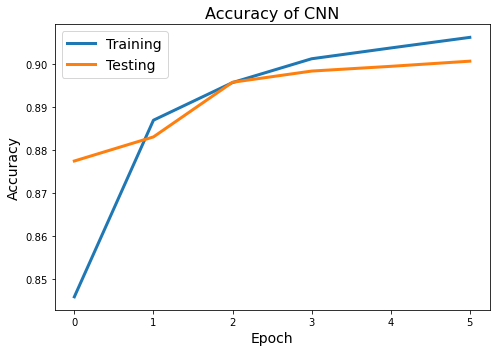

In [57]:
# Visualize accuracy curves
plot_history(history_cnn, title='Accuracy of CNN')

In [58]:
# Predict on new data 
pred_cnn = model_cnn.predict(x_test)

In [59]:
x_test[0:1].shape

(1, 28, 28, 1)

In [60]:
# Let's look at one specific prediction 
y_pred_0 = model_cnn.predict(x_test[19:20])

In [61]:
# What's the class for this image? 
y_pred_0.argmax()

8

<StemContainer object of 3 artists>

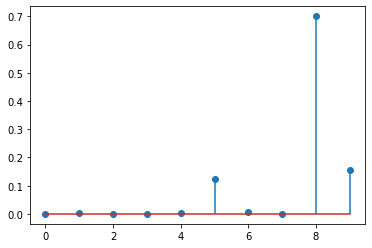

In [62]:
# Look at the predicted probabilities for each class
plt.stem(y_pred_0.ravel())

You can see that on this example, the predicted probability is not concentrated on only one class. The image is difficult to label.

Quelques prédictions avec CNN


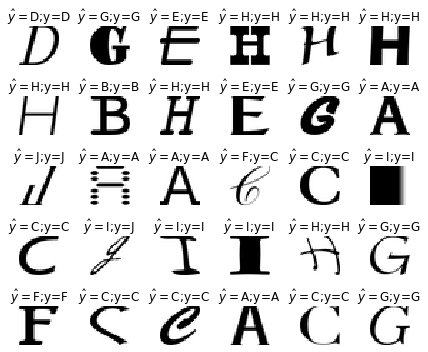

In [63]:
# Let's look at some predictions
print("Quelques prédictions avec CNN")

# plt.figure(figsize=(8, 4))
n_rows = 5
n_cols = 6
plt.figure(figsize=(n_cols, n_rows))


for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_test[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(f"$\hat y=$" +get_label(pred_cnn[i]) +f";"+ f"y={get_label(y_test[i])}", fontsize=12)
    ax.axis("off")
plt.tight_layout()

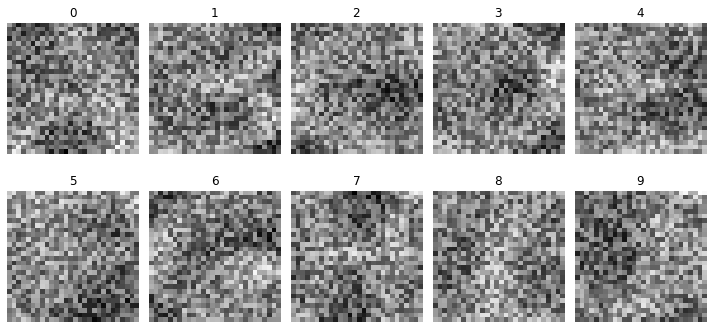

In [64]:
# Visualize the weights 

weights, biases = model_softmax.get_layer('output').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='gray')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()

# A fashionable use case: clothing classification with fashion-mnist

## Exercise

- load data with `fashion_mnist.load_data()` - no validation sets, only train and test sets. 
- labels names are :

`LABEL_NAMES = ['t_shirt', 'pantalon', 'pull', 'robe', 'manteau', 'sandale', 'chemise', 'baskets', 'sac', 'bottes']`

- describe the dataset: what are the shapes? the labels distributions? what does the data look like?
- normalize the images and one-hot encode the labels
- create a model with different successions of 3 layers CONV+POOL+DROP - take inspiration from the examples above. 
- train the model 
- plot the convergence curves 
- make predictions
- study the errors: what kind of clothes are difficult to classify ?


**Take care of the kernel sizes**

For instance

- first layer
   - Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
   - Max pooling with pool size 2 * 2
   - Dropout with probability 0.25
- second layer
   - Convolutional layer with 128 filters and 5 * 5 kernel sizes and 'relu' activation
   - Max pooling with pool size 2 * 2
   - Dropout with probability 0.25
- third layer
   - Convolutional layer with 256 filters and 3 * 3 kernel sizes and 'relu' activation
   - Max pooling with pool size 2 * 2
   - Dropout with probability 0.25
- fourth layer
   - Dense layer with 256 units
   - Dropout with probability 0.5
   - Dense output layer with softmax activation

In [65]:
# Your answer

## Solution

In [66]:
### pour charger les données si le fichier 'MNIST.pickle' est zippé et est en local
import zipfile
#import pickle as pkl

filename = 'data/fashionMNIST.pickle.zip'
archive = zipfile.ZipFile(filename, 'r')

with archive.open('fashionMNIST.pickle') as f:
    data = pkl.load(f)

In [67]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = data

In [68]:
# Look at the format
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


In [69]:
# input image dimensions
img_rows, img_cols = 28, 28

# reshape the images to add the depth - necessary before running a Conv2D layer
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)
60000 train samples
10000 test samples


In [70]:
# import pandas as pd
# Look at the labels
labels = pd.Series(y_test).unique()
num_labels = len(labels)
print(labels)

[9 2 1 6 4 5 7 3 8 0]


Labels are encoded from 0 to 9 (total of 10 classes).

<AxesSubplot:xlabel='class', ylabel='prop'>

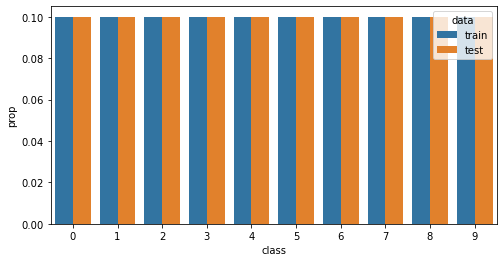

In [71]:
# import matplotlib.pyplot as plt
%matplotlib inline

y_counts = pd.DataFrame({
    'data': np.array(['train'] * num_labels + ['test'] * num_labels),
    'class': np.tile(np.arange(num_labels), 2),
    'prop': np.hstack([np.bincount(y_train) / y_train.shape[0], 
                         np.bincount(y_test) / y_test.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=y_counts, ax=ax)

Train and Test sets are perfectly divided into the same amount of examples in each of the ten classes (so, there are 6000 examples per class in training set and 1000 in test set).

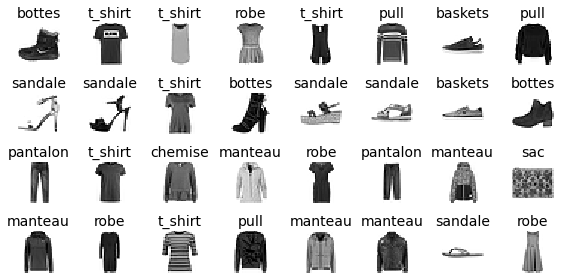

In [73]:
LABEL_NAMES = [
    't_shirt', 'pantalon', 'pull', 'robe', 'manteau', 
    'sandale', 'chemise', 'baskets', 'sac', 'bottes'
]

# Lets us plot some examples
n_rows = 4
n_cols = 8
plt.figure(figsize=(n_cols,n_rows))
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(LABEL_NAMES[y_train[i]], fontsize=14)
    ax.axis("off")

plt.tight_layout()


In [74]:
# Start by normalizing the data
# RUN THIS ONLY ONCE
x_test = x_test / x_train.max() # beware normalization with value from train set
x_train = x_train / x_train.max()


In [75]:
# Let us define our CNN
model_fashion = Sequential(name="FashionCNN")

model_fashion.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu", input_shape=input_shape, name="conv_1"))
model_fashion.add(MaxPooling2D(pool_size=(2, 2), name="maxpool_1"))
model_fashion.add(Dropout(rate=0.25, name="dropout_1"))

model_fashion.add(Conv2D(filters=128, kernel_size=(5, 5), activation="relu", name="conv_2"))
model_fashion.add(MaxPooling2D(pool_size=(2, 2), name="maxpool_2"))
model_fashion.add(Dropout(rate=0.25, name="dropout_2"))

model_fashion.add(Conv2D(filters=256, kernel_size=(3, 3), name="conv_3"))
model_fashion.add(MaxPooling2D(pool_size=(2, 2), name="maxpool_3"))
model_fashion.add(Dropout(rate=0.25, name="dropout_3"))

model_fashion.add(Flatten(name="flatten")) # always need to flatten before Dense

model_fashion.add(Dense(units=256, name="dense_1"))
model_fashion.add(Dropout(rate=0.5, name="dropout_4"))
model_fashion.add(Dense(units=num_labels, activation="softmax", name="output"))


In [76]:
# Summary of the model
model_fashion.summary()

Model: "FashionCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 12, 12, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 8, 8, 128)         204928    
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 4, 4, 128)         0         
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 128)         0         
                                                                 
 conv_3 (Conv2D)             (None, 2, 2, 256)         2

In [77]:
# Compile the model 
model_fashion.compile(
    optimizer="rmsprop", ## Note the choice of optimizer 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [78]:
# Train the model
history_fashion = model_fashion.fit(
                x_train, y_train,
                validation_data=(x_test, y_test),
                epochs=3,
                batch_size=64
                )

Epoch 1/3
938/938 [==============================] - 121s 128ms/step - loss: 0.5596 - accuracy: 0.7950 - val_loss: 0.3843 - val_accuracy: 0.8538
Epoch 2/3
938/938 [==============================] - 117s 124ms/step - loss: 0.3706 - accuracy: 0.8677 - val_loss: 0.3281 - val_accuracy: 0.8849
Epoch 3/3
938/938 [==============================] - 118s 126ms/step - loss: 0.3350 - accuracy: 0.8804 - val_loss: 0.3864 - val_accuracy: 0.8570


In [79]:
# Let's try the same architecture but with a different compiler
# It is convenient to copy-paste and use a new name for the model 

# Let us define our CNN
model_fashion_2 = Sequential(name="FashionCNN")

model_fashion_2.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu", input_shape=input_shape, name="conv_1"))
model_fashion_2.add(MaxPooling2D(pool_size=(2, 2), name="maxpool_1"))
model_fashion_2.add(Dropout(rate=0.25, name="dropout_1"))

model_fashion_2.add(Conv2D(filters=128, kernel_size=(5, 5), activation="relu", name="conv_2"))
model_fashion_2.add(MaxPooling2D(pool_size=(2, 2), name="maxpool_2"))
model_fashion_2.add(Dropout(rate=0.25, name="dropout_2"))

model_fashion_2.add(Conv2D(filters=256, kernel_size=(3, 3), name="conv_3"))
model_fashion_2.add(MaxPooling2D(pool_size=(2, 2), name="maxpool_3"))
model_fashion_2.add(Dropout(rate=0.25, name="dropout_3"))

model_fashion_2.add(Flatten(name="flatten")) # always need to flatten before Dense

model_fashion_2.add(Dense(units=256, name="dense_1"))
model_fashion_2.add(Dropout(rate=0.5, name="dropout_4"))
model_fashion_2.add(Dense(units=num_labels, activation="softmax", name="output"))


# Now in the compiler, we use another optimizer
model_fashion_2.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)


# Note that the description of the model is unchanged
model_fashion_2.summary()

Model: "FashionCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 12, 12, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 8, 8, 128)         204928    
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 4, 4, 128)         0         
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 128)         0         
                                                                 
 conv_3 (Conv2D)             (None, 2, 2, 256)         2

In [80]:
#train the model
batch_size = 256
epochs = 3
history_fash_2 = model_fashion_2.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(x_test, y_test))
# Evaluate its accuracy
score = model_fashion_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/3
235/235 [==============================] - 106s 449ms/step - loss: 2.3026 - accuracy: 0.1108 - val_loss: 2.2863 - val_accuracy: 0.1345
Epoch 2/3
235/235 [==============================] - 102s 434ms/step - loss: 2.2880 - accuracy: 0.1217 - val_loss: 2.2734 - val_accuracy: 0.1110
Epoch 3/3
235/235 [==============================] - 104s 441ms/step - loss: 2.2732 - accuracy: 0.1365 - val_loss: 2.2605 - val_accuracy: 0.1093
Test loss: 2.2604832649230957
Test accuracy: 0.10930000245571136


plot_history(history_fash_2, title='Accuracy of the model with Adadelta optim')

In [85]:
# prediction with the two models
pred1 = model_fashion.predict(x_test)
pred2 = model_fashion_2.predict(x_test)

In [86]:
# Transform numeric labels into name
LABEL_NAMES = [
    't_shirt', 'pantalon', 'pull', 'robe', 'manteau', 
    'sandale', 'chemise', 'baskets', 'sac', 'bottes'
]
def get_label(y):
    return LABEL_NAMES[y.argmax()]


### Compare predicted and true labels
pred1_label = []
pred2_label = []
true_label = []

#pred_label
for i in range(pred1.shape[0]):
    pred1_label.append(get_label(pred1[i]))
    pred2_label.append(get_label(pred2[i]))
    true_label.append(LABEL_NAMES[y_test[i]])

# With the first model    
pd.crosstab(pd.Series(pred1_label),pd.Series(true_label))

col_0,baskets,bottes,chemise,manteau,pantalon,pull,robe,sac,sandale,t_shirt
row_0,,,,,,,,,,
baskets,932,10,0,0,0,0,0,1,32,0
bottes,65,986,0,0,0,0,0,3,18,0
chemise,0,0,521,106,1,18,23,2,0,30
manteau,0,0,18,459,1,10,10,0,0,0
pantalon,0,0,1,1,984,1,9,2,0,2
pull,0,1,166,378,0,938,17,12,0,24
robe,0,0,22,51,12,12,910,3,0,16
sac,0,0,25,2,1,1,1,976,0,12
sandale,3,3,0,0,0,0,0,1,950,2


In [87]:
# With the second model
pd.crosstab(pd.Series(pred2_label),pd.Series(true_label))

col_0,baskets,bottes,chemise,manteau,pantalon,pull,robe,sac,sandale,t_shirt
row_0,,,,,,,,,,
bottes,2,0,0,0,0,0,0,0,46,0
manteau,933,960,1000,1000,973,1000,970,938,575,990
pantalon,0,0,0,0,25,0,16,0,7,0
pull,0,0,0,0,0,0,0,0,17,1
robe,0,0,0,0,0,0,5,0,0,0
sac,65,40,0,0,2,0,8,62,355,8
t_shirt,0,0,0,0,0,0,1,0,0,1


Quelques prédictions 


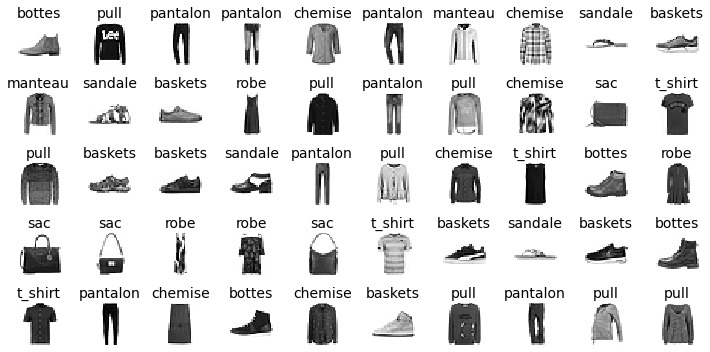

In [88]:
print("Quelques prédictions ")

n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols, n_rows))


for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_test[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(get_label(pred1[i]), fontsize=14)
   
    ax.axis("off")
plt.tight_layout()